In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.io import wavfile

Fourier Series

In [ ]:
import numpy as np

def getFourierCoeffs(coefs, T, K=50):
    coefs = np.asarray(coefs, dtype=float)
    T = np.asarray(T, dtype=float)
    n = coefs.shape[0]
    if coefs.shape != (n, 4):
        raise ValueError("coefs must be shape (n,4)")
    if T.shape[0] != n + 1:
        raise ValueError("T must have length n+1")

    alpha = coefs[:, 0]
    beta  = coefs[:, 1]
    gamma = coefs[:, 2]
    delta = coefs[:, 3]

    # tau_i = interval length
    tau = T[1:] - T[:-1]   # shape (n,)
    L = T[-1] - T[0]
    if L == 0:
        raise ValueError("Total length L = T[-1] - T[0] must be nonzero.")

    # a0 from the image formula
    a0 = (1.0 / L) * np.sum(
        alpha * (tau**4) / 4.0
        + beta  * (tau**3) / 3.0
        + gamma * (tau**2) / 2.0
        + delta * (tau)
    )

    ak = np.zeros(K, dtype=float)
    bk = np.zeros(K, dtype=float)

    # Precompute endpoints arrays for convenience
    T_i = T[:-1]     # left endpoints (shape n)
    T_ip1 = T[1:]    # right endpoints

    for k in range(1, K+1):
        omega = 2.0 * np.pi * k / L
        w1 = omega
        w2 = omega**2
        w3 = omega**3
        w4 = omega**4

        sin_Ti   = np.sin(w1 * T_i)
        sin_Tip1 = np.sin(w1 * T_ip1)
        cos_Ti   = np.cos(w1 * T_i)
        cos_Tip1 = np.cos(w1 * T_ip1)

        term_alpha_a = (
            alpha * (
                (tau**3 * sin_Tip1) / w1
                + (3.0 * tau**2 * cos_Tip1) / w2
                - (6.0 * tau * sin_Tip1) / w3
                - (6.0 * (cos_Tip1 - cos_Ti)) / w4
            )
        )

        term_beta_a = (
            beta * (
                (tau**2 * sin_Tip1) / w1
                + (2.0 * tau * cos_Tip1) / w2
                - (2.0 * (sin_Tip1 - sin_Ti)) / w3
            )
        )

        term_gamma_a = (
            gamma * (
                (tau * sin_Tip1) / w1
                + (cos_Tip1 - cos_Ti) / w2
            )
        )

        term_delta_a = (
            delta * ( (sin_Tip1 - sin_Ti) / w1 )
        )

        sum_a_intervals = np.sum(term_alpha_a + term_beta_a + term_gamma_a + term_delta_a)
        ak[k-1] = (2.0 / L) * sum_a_intervals

        term_alpha_b = (
            alpha * (
                - (tau**3 * cos_Tip1) / w1
                + (3.0 * tau**2 * sin_Tip1) / w2
                + (6.0 * tau * cos_Tip1) / w3
                - (6.0 * (sin_Tip1 - sin_Ti)) / w4
            )
        )

        term_beta_b = (
            beta * (
                - (tau**2 * cos_Tip1) / w1
                + (2.0 * tau * sin_Tip1) / w2
                + (2.0 * (cos_Tip1 - cos_Ti)) / w3
            )
        )

        term_gamma_b = (
            gamma * (
                - (tau * cos_Tip1) / w1
                + (sin_Tip1 - sin_Ti) / w2
            )
        )

        term_delta_b = (
            delta * ( - (cos_Tip1 - cos_Ti) / w1 )
        )

        sum_b_intervals = np.sum(term_alpha_b + term_beta_b + term_gamma_b + term_delta_b)
        bk[k-1] = (2.0 / L) * sum_b_intervals

    return a0, ak, bk

In [38]:
def fourier_series(t, terms, a0, ak, bk, L):
    t = np.asarray(t, dtype=float)
    y = np.full_like(t, a0, dtype=float)
    for k in range(1, terms+1):
        omega = 2 * np.pi * k / L
        y += ak[k-1] * np.cos(omega * t) + bk[k-1] * np.sin(omega * t)
    return y

In [ ]:

def visualizeFourier(data):
    x = data.iloc[:, 0].values
    y = data.iloc[:, 1].values

    cs = CubicSpline(x, y)

    x_smooth = np.linspace(min(x), max(x), 500)
    y_smooth = cs(x_smooth)
    cubicSpline = np.transpose(cs.c)

    a0, ak, bk = getFourierCoeffs(coefs=cubicSpline, T=x, K=50)

    L = x[-1] - x[0]

    terms = 50

    t_plot_long = np.linspace(x[0] - L, x[-1] + L, 4000)
    y_fourier_long = fourier_series(t_plot_long, terms, a0, ak, bk, L)

    plt.figure(figsize=(10,5))
    plt.plot(t_plot_long, y_fourier_long,
                label=f"Fourier Series (K={terms})", linewidth=2)

    plt.scatter(x, y, color='red', s=12, label="Original Data", zorder=5)

    plt.axvline(x[0], color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x[-1], color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x[0] - L, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x[-1] + L, color='gray', linestyle='--', alpha=0.3)

    plt.title("Fourier Series Reconstruction (Extended to Show Periodicity)")
    plt.xlabel("t")
    plt.ylabel("s(t)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


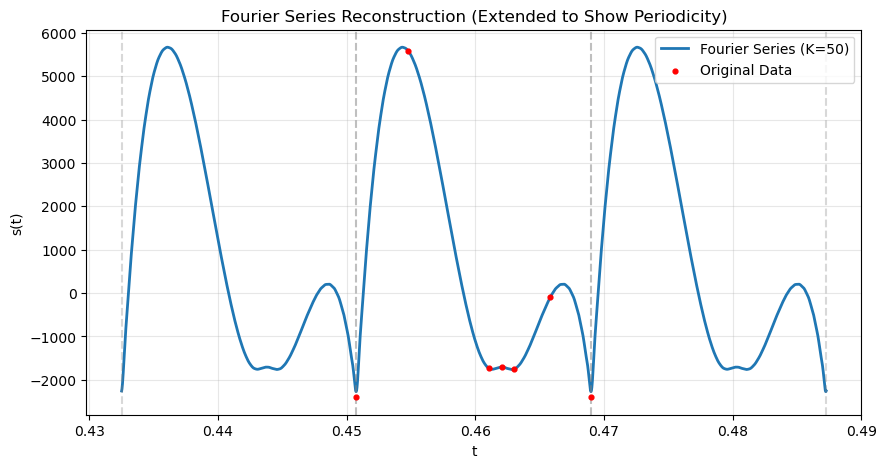

In [40]:
data = pd.read_csv("./plot_data/Bass A4 (A2).csv", header=None)
visualizeFourier(data)


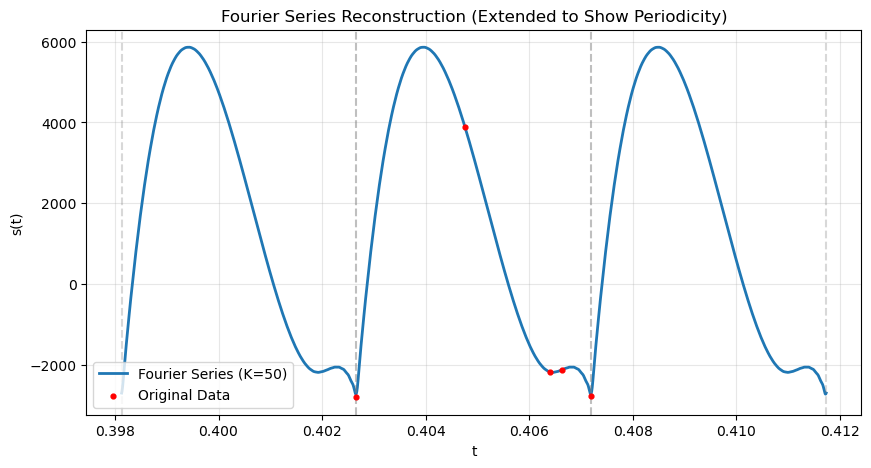

In [41]:
data = pd.read_csv("./plot_data/Guitar A4.csv", header=None)
visualizeFourier(data)

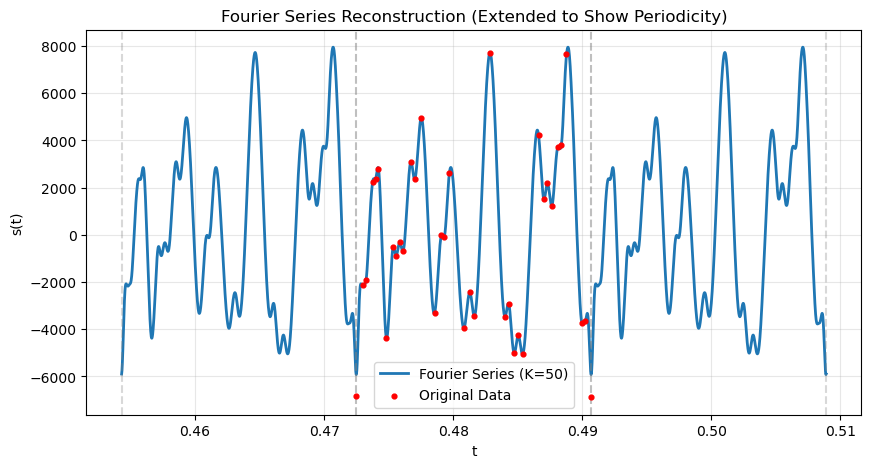

In [43]:
data = pd.read_csv("./plot_data/Guitar A Major.csv", header=None)
visualizeFourier(data)

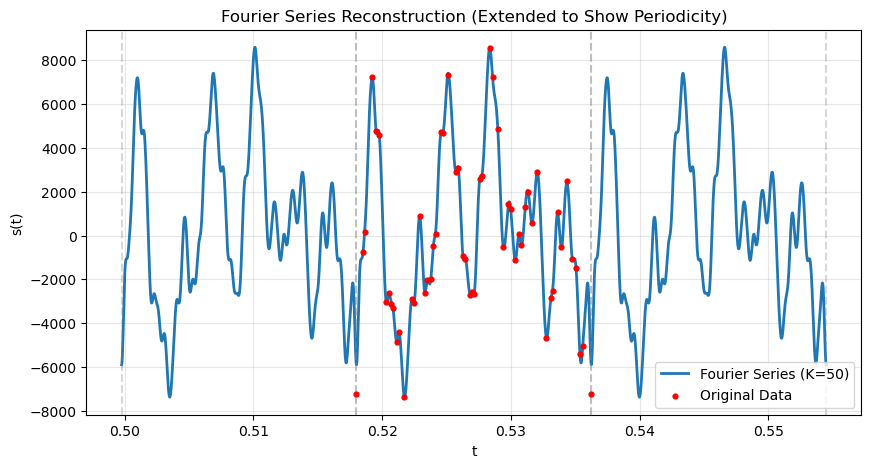

In [42]:
data = pd.read_csv("./plot_data/All Three.csv", header=None)
visualizeFourier(data)

Fourier Transform